In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

def preprocess_text(text):
    """
    Preprocess a given text string by normalizing, tokenizing, removing stop words,
    and lemmatizing.
    """
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# --- Helpers ---
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.strip().str.lower()
    return df

def ensure_date_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find a likely date column, parse to datetime, and write back to a unified 'date' column.
    If no date-like column exists, create an empty 'date' column.
    """
    candidates = [
        "date", "published", "publish_date", "publication_date",
        "pub_date", "created_at", "time", "timestamp"
    ]
    date_col = next((c for c in candidates if c in df.columns), None)
    if date_col is None:
        df["date"] = pd.NaT
    else:
        df["date"] = pd.to_datetime(df[date_col], errors="coerce")
    # Write dates as ISO strings (YYYY-MM-DD); keep NaN if unknown
    df["date"] = df["date"].dt.strftime("%Y-%m-%d")
    return df

# --- Load ---
df_true = pd.read_csv("True.csv")
df_false = pd.read_csv("Fake.csv")

# Normalize headers to avoid case/space issues
df_true = normalize_columns(df_true)
df_false = normalize_columns(df_false)

# Make sure we have a usable 'date' column in both
df_true = ensure_date_column(df_true)
df_false = ensure_date_column(df_false)

print("Unprocessed True:")
print(df_true.head())

print("Unprocessed Fake:")
print(df_false.head())

# --- Preprocess ---
# Guard for missing title/text columns
required = {"title", "text"}
missing_true = required - set(df_true.columns)
missing_false = required - set(df_false.columns)
if missing_true:
    raise KeyError(f"True.csv missing required columns: {missing_true}")
if missing_false:
    raise KeyError(f"Fake.csv missing required columns: {missing_false}")

df_true["processed_title"] = df_true["title"].astype(str).apply(preprocess_text)
df_false["processed_title"] = df_false["title"].astype(str).apply(preprocess_text)
df_true["processed_text"]  = df_true["text"].astype(str).apply(preprocess_text)
df_false["processed_text"] = df_false["text"].astype(str).apply(preprocess_text)

# --- Save ONLY processed columns + date ---
df_true[["processed_title", "processed_text", "date"]].to_csv("preprocessed_True.csv", index=False)
df_false[["processed_title", "processed_text", "date"]].to_csv("preprocessed_Fake.csv", index=False)

print("Processed True (with date):")
print(df_true[["processed_title", "processed_text", "date"]].head())

print("Processed Fake (with date):")
print(df_false[["processed_title", "processed_text", "date"]].head())


Char TF-IDF shapes: (31066, 30000) (7767, 30000)
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3614
           1       0.98      0.99      0.98      4153

    accuracy                           0.98      7767
   macro avg       0.98      0.98      0.98      7767
weighted avg       0.98      0.98      0.98      7767

ROC AUC: 0.9982


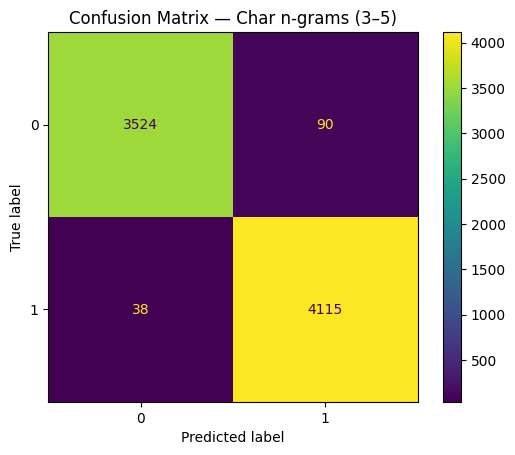

Top TRUE (class 1) char n-grams: ['eut', 'reut', 'eute', ' reu', 'reu', 'uter', 'ters', ' sai', 'said', 'sai', 'ers ', 'ute', 'aid', 'rs ', 'aid ', 'id ', 'ers', ' u ', 'day', 'day ', 'sday', 'sda', 'rs u', 'esda', 'esd']
Top FAKE (class 0) char n-grams: [' via', 'via ', 'via', ' vi', 'deo', 'ideo', ' vid', ' ima', 'imag', 'deo ', 'ly ', 'ima', 'vide', 'mage', 'eo ', 'vid', ' rea', 'gop', 'gop ', 'mag', 'mr ', ' mr', ' gop', ' mr ', 'rea']


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, cross_val_score

# pipe_char = Pipeline([
#     ("tfidf", TfidfVectorizer(
#         analyzer="char",
#         ngram_range=(3, 5),
#         min_df=5,
#         max_df=0.9,
#         max_features=50000,   # adjust if memory is tight
#         lowercase=True
#     )),
#     ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)),
# ])

# gkf = GroupKFold(n_splits=5)
# cv_scores_char = cross_val_score(
#     pipe_char,
#     X_train_txt, y_train,
#     cv=gkf.split(X_train_txt, y_train, groups=train_groups),
#     scoring="f1"
# )
# print("Char n-gram (3–5) leak-free GroupKFold F1 (train):", cv_scores_char.mean())
# print("Per-fold F1:", cv_scores_char)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Vectorize (fit on train only)
vectorizer_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 4),
    min_df=5,
    max_df=0.9,
    max_features=30000,   # reduce if you hit memory limits
    lowercase=True
)
X_train_char = vectorizer_char.fit_transform(X_train_txt)
X_test_char  = vectorizer_char.transform(X_test_txt)

print("Char TF-IDF shapes:", X_train_char.shape, X_test_char.shape)

# Train & evaluate
model_char = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
model_char.fit(X_train_char, y_train)

y_pred_char = model_char.predict(X_test_char)
print(classification_report(y_test, y_pred_char))

if hasattr(model_char, "predict_proba"):
    auc_char = roc_auc_score(y_test, model_char.predict_proba(X_test_char)[:, 1])
    print("ROC AUC:", round(auc_char, 4))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model_char, X_test_char, y_test)
plt.title("Confusion Matrix — Char n-grams (3–5)")
plt.show()

# Top positive/negative character n-grams
coef = model_char.coef_[0]
feats = vectorizer_char.get_feature_names_out()
top_pos = np.argsort(coef)[-25:][::-1]
top_neg = np.argsort(coef)[:25]

print("Top TRUE (class 1) char n-grams:", [feats[i] for i in top_pos])
print("Top FAKE (class 0) char n-grams:", [feats[i] for i in top_neg])


Loaded shapes — fake: (23481, 5)  true: (21417, 5)  merged: (38833, 5)
Dropped exact duplicate rows: 6065 (remaining: 38833)
Train size: 31066  Test size: 7767
Leak-safe StratifiedKFold F1 (train): 0.9719457430007374
Per-fold F1: [0.97004745 0.97664038 0.96984103 0.9699776  0.97322226]

=== Baseline (word TF-IDF + base tells removed) — Held-out Test ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3581
           1       0.97      0.98      0.97      4186

    accuracy                           0.97      7767
   macro avg       0.97      0.97      0.97      7767
weighted avg       0.97      0.97      0.97      7767

ROC AUC: 0.9958
AUCPR : 0.9961
MCC   : 0.9412
Top TRUE tokens: ['said', 'presidential', 'told', 'representative', 'spokesman', 'democratic', 'minister', 'rival', 'statement', 'ly', 'barack', 'comment', 'moscow', 'britain', 'senate', 'agency', 'house', 'republican', 'united', 'militant', 'citing', 'reporter', 'measur

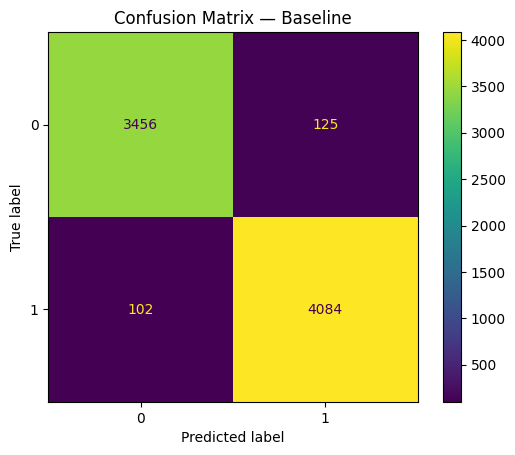

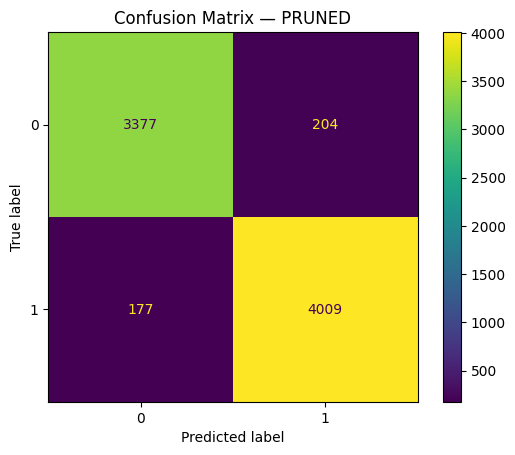

In [ ]:
"""
Baseline fake-vs-true text classifier WITHOUT time-based splitting.

What this does:
- Loads preprocessed CSVs (expects 'processed_title' and 'processed_text', and a 'label' column or infers it)
- Builds a combined text field
- Drops empty rows and exact duplicates
- Performs a stratified random train/test split (no date/time usage)
- Uses leak-safe CV via a Pipeline (TF-IDF fit inside each fold)
- Removes a set of publisher/style "tells" (stop words)
- Trains Logistic Regression, reports metrics (Accuracy/F1 + ROC AUC, AUCPR, MCC)
- Auto-prunes top label-correlated tokens and re-runs CV/test
"""

from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,   # AUCPR
    matthews_corrcoef,         # MCC
    ConfusionMatrixDisplay,
)

###
# Configuration
###
DATA_DIR = Path(".")
FAKE_CSV = DATA_DIR / "preprocessed_Fake.csv"   # expects processed_title, processed_text, optional date, optional label
TRUE_CSV = DATA_DIR / "preprocessed_True.csv"

RANDOM_STATE = 42
TEST_SIZE = 0.20

# Base "tells" to remove up-front (mostly publisher/style/boilerplate)
BASE_TELLS = {
    "reuters","washington","monday","tuesday","wednesday","thursday","friday","saturday","sunday",
    "nov","oct","sep","edt","london","york","mr","rep","sen",
    "video","image","read","watch","featured","getty","breaking","http","https","com","pic"
}

# How many top tokens (per class) to auto-ban after baseline model fit
TOP_K_TELLS_PER_CLASS = 50

# TF-IDF settings (word analyzer)
WORD_MAX_FEATURES = 5000
WORD_MIN_DF = 5
WORD_MAX_DF = 0.8
WORD_TOKEN_PATTERN = r"(?u)\b[a-zA-Z][a-zA-Z\-']+\b"

###
# Functions
###
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize column names to lowercase and strip whitespace.

    Args:
        df: Input DataFrame.

    Returns:
        DataFrame with normalized column names.
    """
    df.columns = df.columns.str.strip().str.lower()
    return df


def build_combined(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a 'combined' text field from 'processed_title' and 'processed_text'.

    Safely handles missing values, converts to strings, strips whitespace, and
    joins with a single space.

    Args:
        df: DataFrame with 'processed_title' and 'processed_text' columns.

    Returns:
        DataFrame with a new 'combined' column.
    """
    df["processed_title"] = df["processed_title"].fillna("").astype(str).str.strip()
    df["processed_text"]  = df["processed_text"].fillna("").astype(str).str.strip()
    df["combined"] = (df["processed_title"] + " " + df["processed_text"]).str.strip()
    return df


def evaluate_and_report(name: str, model: LogisticRegression, X_test, y_test) -> None:
    """
    Print a suite of metrics on a held-out test set.

    Args:
        name: Label for this evaluation block.
        model: Trained classifier with predict / predict_proba.
        X_test: Test features (sparse matrix or ndarray).
        y_test: Ground-truth labels (1D array-like).

    Returns:
        None; prints metrics.
    """
    y_pred = model.predict(X_test)
    print(f"\n=== {name} — Held-out Test ===")
    print(classification_report(y_test, y_pred))
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
        print("ROC AUC:", round(roc_auc_score(y_test, probs), 4))
        print("AUCPR :", round(average_precision_score(y_test, probs), 4))
        print("MCC   :", round(matthews_corrcoef(y_test, y_pred), 4))
    else:
        print("MCC   :", round(matthews_corrcoef(y_test, y_pred), 4))


def leak_safe_cv_f1(
    X_text_train: List[str],
    y_train: np.ndarray,
    stop_words_list: List[str],
    n_splits: int = 5
) -> np.ndarray:
    """
    Compute leak-safe StratifiedKFold F1 scores on raw training text.

    Uses a scikit-learn Pipeline so TF-IDF is fit **inside each fold**, preventing
    vocabulary/IDF leakage from train to validation.

    Args:
        X_text_train: Raw training texts.
        y_train: Training labels (1D numpy array or list).
        stop_words_list: Stopwords for the TfidfVectorizer.
        n_splits: Number of folds for StratifiedKFold.

    Returns:
        Numpy array of per-fold F1 scores.
    """
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=WORD_MAX_FEATURES,
            token_pattern=WORD_TOKEN_PATTERN,
            min_df=WORD_MIN_DF,
            max_df=WORD_MAX_DF,
            stop_words=stop_words_list
        )),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)),
    ])
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe, X_text_train, y_train, cv=skf, scoring="f1")
    return scores


def print_top_tokens(model: LogisticRegression, vectorizer: TfidfVectorizer, k: int = 25) -> None:
    """
    Print top positive/negative tokens by coefficient magnitude from a trained LogisticRegression.

    Args:
        model: Trained LogisticRegression with coef_ shape (1, n_features).
        vectorizer: Fitted TfidfVectorizer providing get_feature_names_out().
        k: Number of tokens to show for each side.

    Returns:
        None; prints lists.
    """
    coef = model.coef_[0]
    feats = vectorizer.get_feature_names_out()
    top_pos_idx = np.argsort(coef)[-k:][::-1]
    top_neg_idx = np.argsort(coef)[:k]
    print("Top TRUE tokens:", [feats[i] for i in top_pos_idx])
    print("Top FAKE tokens:", [feats[i] for i in top_neg_idx])

###
# Load & prepare data
###
df_fake = normalize_cols(pd.read_csv(FAKE_CSV))
df_true = normalize_cols(pd.read_csv(TRUE_CSV))

# Ensure labels (0=fake, 1=true)
if "label" not in df_fake.columns: df_fake["label"] = 0
if "label" not in df_true.columns: df_true["label"] = 1

# Build combined text
df_fake = build_combined(df_fake)
df_true = build_combined(df_true)

# Merge, drop empties and exact duplicates
df = pd.concat([df_fake, df_true], ignore_index=True)
df = df[df["combined"] != ""].reset_index(drop=True)
orig_n = len(df)
df = df.drop_duplicates(subset=["combined"]).reset_index(drop=True)
print(f"Loaded shapes — fake: {df_fake.shape}  true: {df_true.shape}  merged: {df.shape}")
print(f"Dropped exact duplicate rows: {orig_n - len(df)} (remaining: {len(df)})")

# Features/labels
X_text = df["combined"].astype(str).tolist()
y = pd.to_numeric(df["label"], errors="raise").to_numpy(dtype=np.int8)

###
# Stratified random split (no time-based aspect)
###
X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    X_text, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train size:", len(y_train), " Test size:", len(y_test))

###
# CV on TRAIN with base tells removed
###
custom_stop = set(ENGLISH_STOP_WORDS) | BASE_TELLS
stop_words_list = sorted(custom_stop)

cv_scores = leak_safe_cv_f1(X_train_txt, y_train, stop_words_list, n_splits=5)
print("Leak-safe StratifiedKFold F1 (train):", cv_scores.mean())
print("Per-fold F1:", cv_scores)

###
# Fit baseline model and evaluate on TEST
###
vec_word = TfidfVectorizer(
    max_features=WORD_MAX_FEATURES,
    token_pattern=WORD_TOKEN_PATTERN,
    min_df=WORD_MIN_DF,
    max_df=WORD_MAX_DF,
    stop_words=stop_words_list
)
X_train = vec_word.fit_transform(X_train_txt)
X_test  = vec_word.transform(X_test_txt)

model_base = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
model_base.fit(X_train, y_train)

evaluate_and_report("Baseline (word TF-IDF + base tells removed)", model_base, X_test, y_test)
print_top_tokens(model_base, vec_word, k=25)

###
# Auto-prune top label-correlated tokens, retrain, re-evaluate
###
coef = model_base.coef_[0]
feats = vec_word.get_feature_names_out()
top_pos = [w for _, w in sorted(zip(coef, feats), reverse=True)[:TOP_K_TELLS_PER_CLASS]]
top_neg = [w for _, w in sorted(zip(coef, feats))[:TOP_K_TELLS_PER_CLASS]]
auto_ban = set(top_pos + top_neg)

stop_words_list_pruned = sorted(set(stop_words_list) | auto_ban)

cv_scores_pruned = leak_safe_cv_f1(X_train_txt, y_train, stop_words_list_pruned, n_splits=5)
print("\nLeak-safe StratifiedKFold F1 (train) — PRUNED:", cv_scores_pruned.mean())
print("Per-fold F1 (pruned):", cv_scores_pruned)

vec_word_pruned = TfidfVectorizer(
    max_features=WORD_MAX_FEATURES,
    token_pattern=WORD_TOKEN_PATTERN,
    min_df=WORD_MIN_DF,
    max_df=WORD_MAX_DF,
    stop_words=stop_words_list_pruned
)
X_train_p = vec_word_pruned.fit_transform(X_train_txt)
X_test_p  = vec_word_pruned.transform(X_test_txt)

model_pruned = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
model_pruned.fit(X_train_p, y_train)

evaluate_and_report("PRUNED (auto-ban top tokens per class)", model_pruned, X_test_p, y_test)
print_top_tokens(model_pruned, vec_word_pruned, k=25)

###
# Confusion matrices
###
ConfusionMatrixDisplay.from_estimator(model_base, X_test, y_test)
plt.title("Confusion Matrix — Baseline")
plt.show()

ConfusionMatrixDisplay.from_estimator(model_pruned, X_test_p, y_test)
plt.title("Confusion Matrix — PRUNED")
plt.show()


In [20]:
import pandas as pd
import numpy as np

# Build a test frame to inspect mistakes
test_df = pd.DataFrame({
    "text": X_test_txt,
    "y_true": y_test,
    "y_pred": y_pred,
    "p_true": model.predict_proba(X_test)[:, 1]
})

# Most confident wrong predictions
wrong = test_df[test_df.y_true != test_df.y_pred].copy()
wrong["margin"] = np.abs(wrong["p_true"] - 0.5)
print("Wrong preds:", len(wrong))
print("\nTop 10 most confident errors:")
display(wrong.sort_values("margin", ascending=False).head(10)[["y_true","y_pred","p_true","text"]])

# Quick counts by error type
print("\nFalse positives (pred 1, true 0):", (wrong.y_pred.eq(1) & wrong.y_true.eq(0)).sum())
print("False negatives (pred 0, true 1):", (wrong.y_pred.eq(0) & wrong.y_true.eq(1)).sum())


Wrong preds: 3899

Top 10 most confident errors:


,y_true,y_pred,p_true,text
215,1,0,0.999858,hadi call yemeni rise houthis saleh death live...
4326,0,1,0.005650,best case trump presidency come foreigner live...
6289,0,1,0.007551,donald trump first campaign tv ad worse imagin...
7436,0,1,0.008883,actress emmy rossum fire back trump fan disgus...
5887,0,1,0.009635,meryl streep hammered trump heartbreaking huma...
5059,0,1,0.010194,local news station might turning pro trump pro...
6648,0,1,0.010513,sarah jessica parker fear attacked killed trum...
2353,0,1,0.011398,live feed 1 00 p est 100 fed american rally c ...
6714,0,1,0.012156,watch angry white actor silent meltdown meryl ...
7609,0,1,0.012828,elizabeth warren burn trump attacking hillary ...



False positives (pred 1, true 0): 1962
False negatives (pred 0, true 1): 1937
